For our data set we are working with the rec01.lfp and rec01_BehavElectrDataLFP.mat data in which we only used one session. Ideally we would have used more sessions but we believed that one session would be sufficent(our professor approved of this idea). We used a modified LustGetData.ipynb that outputted a clean data set that only had data points while the rat was at the drinking port. We only used the data where the rat was at the drinking point since short wave ripples, which we are interested in, only occur when the rat is stationary. There could be other points where the rat is stationary and not at the port but we chose to ignore this as the majority of that stationary period of a rat would be when it is at the drinking port. We also only used 8 channels in the middle as channels in the middle would most likely be where the channels that best record the ripple events are. Although there were originally 256 channels, this proved too computionally intense to use. We used average ripples per second (per trial) and average duration of ripples (per trial) as our X and trial number as our Y. We believed that we could discover a relationship between this X and Y using linear regression. We used OLS from statsmodel since it gives us a simple summary of the statistics. In terms of our data we did a 80-20 train-test split for our regession. We decided not to do k-fold validation as our model proved to find no sigificant relationships between our X and Y thus we felt like there was no need to do such. We used a frequency sampling rate of 625. This is because the ripples that we wanted to detect existed between 150 and 250 hertz, so we needed a high sampling frequency rate to ensure that we could capture all of the data that we needed. In our OLS we got a R^2 of 5.1 percent, meaning that 5.1 percent of all of the variance in Y could be explained by X. This meant that our variables and entire model proved to be statisically insigificant, thus there was no found relationship between the average ripple per second per trial, the average duration of an ripple event per trial and the trial number. In the cells below there are explanations of what we did and why we did it.

In [261]:
!pip install ripple_detection #if needed


93827.03s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [262]:
#Import required libraries, methods and helper functions
from scipy.signal import decimate
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.signal import sosfiltfilt, butter
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter


def compAnly(Track, fs):
    """
    Input:
    Track = Contains information on the session pertaining to the track
    fs = sampling frequency

    Output:
    lapID = Data stored in the format listed below

    lapID format:
    Column 0: Trial Number
    Column 1: Maze arm (1/2/3)
    Column 2: Correct (0/1)
    Column 3: other/first approach/port/last departure (0/1/2/3)
    Column 4: position in mm
    """

    dec = 1250//fs #decimation factor

    lapID = np.array([ np.squeeze(Track["lapID"][0][0])[::dec] ])
    lapID = np.append(lapID, [ np.squeeze(Track["mazeSect"][0][0])[::dec] ], axis = 0)
    lapID = np.append(lapID, [ np.squeeze(Track["corrChoice"][0][0])[::dec] ], axis = 0)
    lapID = np.append(lapID, np.zeros((1, len(lapID[0]))), axis = 0)
    lapID = np.append(lapID, decimate(Track["xMM"][0][0].T,dec), axis =0)
    lapID = lapID.T

    # Filter values and construct column 3
    lapID[np.in1d(lapID[:,1], np.array(range(4, 10)), invert = True), 1] = 0
    lapID[lapID[:, 1] > 6, 3] = 2
    lapID[lapID[:, 1] > 0, 1] = (lapID[lapID[:,1] > 0, 1] - 1) % 3 + 1
    lapID[lapID[:, 1] == 0, :] = 0

    # Identify samples corresponding to the first period when the animal enters the maze section
    for i in range(1, int(np.max(lapID[:, 0]) + 1)):
        r = np.logical_and(lapID[:, 0] == i, lapID[:, 3] == 2)
        inds = np.where(lapID[:, 0] == i)[0]
        lapID[inds[inds < np.where(r > 0)[0][0]], 3] = 1
        lapID[inds[inds > np.where(r > 0)[0][-1]], 3] = 3

    # Return structured data
    return lapID


In [263]:
# Load the .npy file clean data from Lusting_data.py
neuro_data = np.load('/Users/tommylu/Downloads/neuro_data.npy') # replace this with your file location

fs = 625 #sampling rate in Hz
data_dir = "/Users/tommylu/Downloads/" # Replace this with your file location

# Specify data files
mat_file = data_dir + "rec01_BehavElectrDataLFP.mat" # contains spiking and behavioral data

# Extract behavior
mat = io.loadmat(mat_file, variable_names = ['Track'])#
lapID = compAnly(mat['Track'],fs)
lapID = lapID[lapID[:, 3] == 2] # We only get care about when the rat is at the port drinking


Here we plotted the power spectrum of each of our 8 trials we could not find any channels of note

/Users/tommylu/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


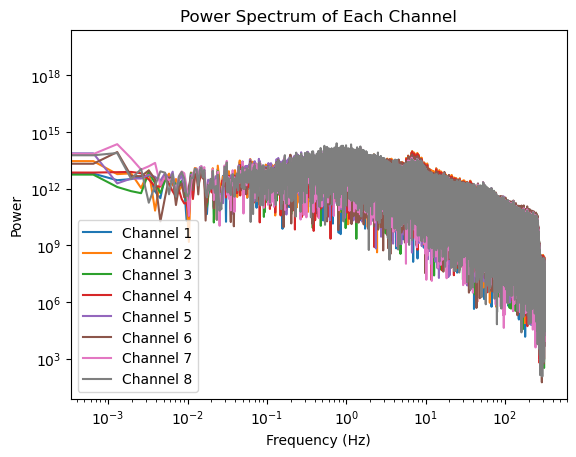

In [264]:
data = neuro_data 
# Sampling frequency
fs = 625  # Replace with your actual sampling frequency

# Initialize an array to hold the power sums
power_sums = np.zeros(data.shape[1])

# Calculate the power spectrum for each channel and plot it
for i in range(data.shape[1]):
    # Compute the Fourier Transform of the signal
    yf = np.fft.fft(data[:, i])

    # Compute the two-sided power spectrum
    ps = np.abs(yf)**2

    # Compute the one-sided power spectrum (only positive frequencies)
    if data.shape[0] % 2 == 0:  # if the number of points is even
        ps = ps[:data.shape[0]//2] * 2
    else:  # if the number of points is odd
        ps = ps[:data.shape[0]//2 + 1] * 2

    ps_smoothed = savgol_filter(ps, 303, 10)  # window size 51, polynomial order 3

    # Calculate the corresponding frequency values
    freqs = np.fft.fftfreq(data.shape[0], 1/fs)[:ps_smoothed.shape[0]]

    # Sum the power spectrum to find the total power for this channel
    power_sums[i] = np.sum(ps_smoothed)

    # Plot the power spectrum on a log-log scale
    plt.loglog(freqs, ps, label=f'Channel {i+1}')

# Decorate the plot
plt.title('Power Spectrum of Each Channel')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.legend()
plt.show()

Since we could not find any channels of note we split up the channels such that it is split up and plotted by channel we then look at 150-250 hertz to see if there any channels that had more ripples than others we did not find one.

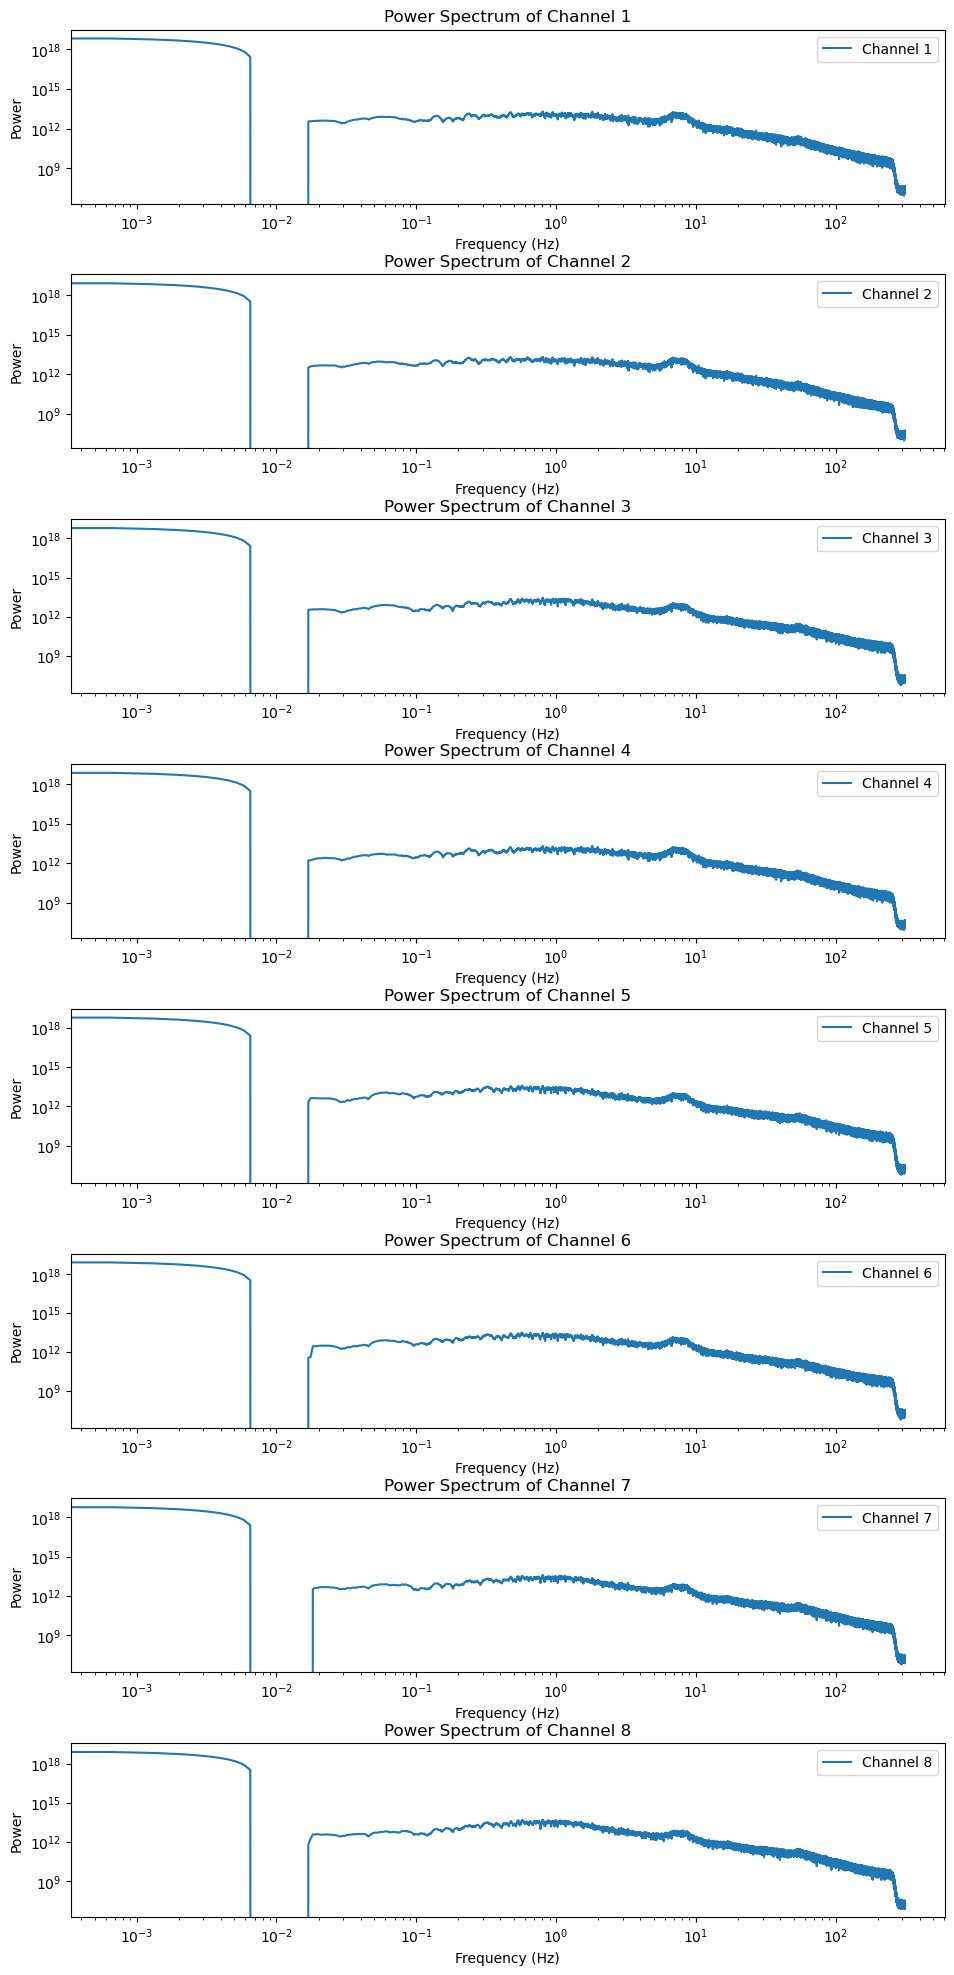

In [265]:
# Initialize an array to hold the power sums
power_sums = np.zeros(data.shape[1])

# Setting up subplots for individual channel plots
fig, axes = plt.subplots(data.shape[1], 1, figsize=(10, 20))
fig.tight_layout(pad=3.0)

# Calculate the power spectrum for each channel and plot it
for i in range(data.shape[1]):
    # Compute the Fourier Transform of the signal
    yf = np.fft.fft(data[:, i])

    # Compute the two-sided power spectrum
    ps = np.abs(yf)**2

    # Compute the one-sided power spectrum (only positive frequencies)
    if data.shape[0] % 2 == 0:
        ps = ps[:data.shape[0]//2] * 2
    else:
        ps = ps[:data.shape[0]//2 + 1] * 2

    # Smooth the power spectrum using Savitzky-Golay filter
    ps_smoothed = savgol_filter(ps, 51, 3)  # window size 51, polynomial order 3

    # Calculate the corresponding frequency values
    freqs = np.fft.fftfreq(data.shape[0], 1/fs)[:ps_smoothed.shape[0]]

    # Sum the power spectrum to find the total power for this channel
    power_sums[i] = np.sum(ps_smoothed)

    # Plot the smoothed power spectrum on a log-log scale in a separate subplot
    axes[i].loglog(freqs, ps_smoothed, label=f'Channel {i+1}')
    axes[i].set_title(f'Power Spectrum of Channel {i+1}')
    axes[i].set_xlabel('Frequency (Hz)')
    axes[i].set_ylabel('Power')
    axes[i].legend()

plt.show()

We decide to then look at a single trial and look at a single ripple event to see if there was any channel where the ripple was the clearest, again tho there was no significant differences so we choose channel 6 to use without any reason

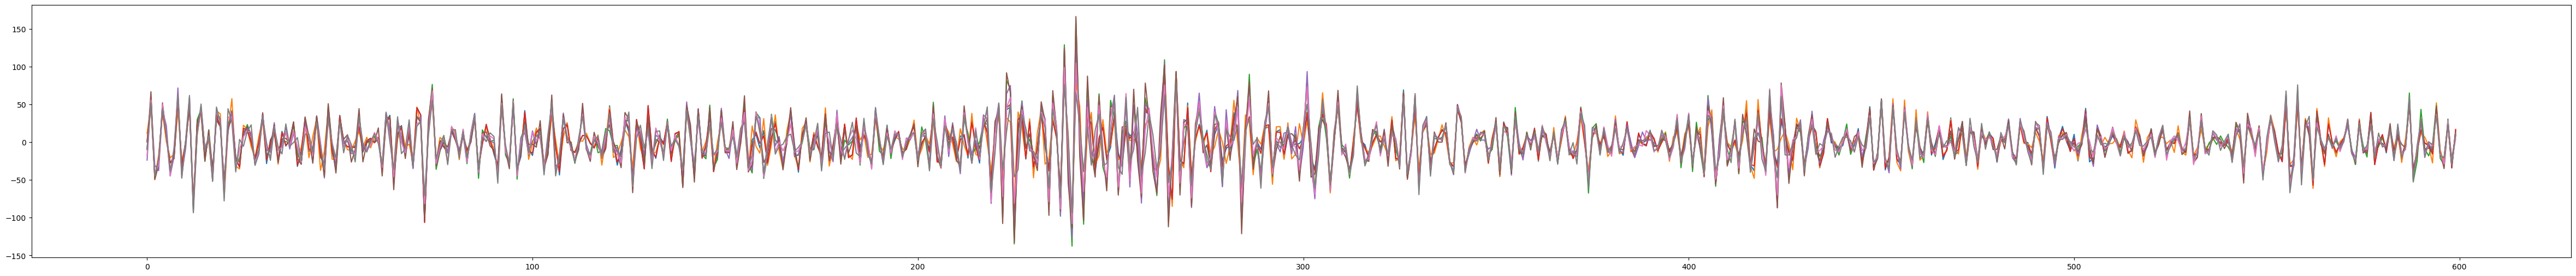

In [266]:
sos = butter(2, 150, btype='highpass', output='sos', fs=625)
y = sosfiltfilt(sos, neuro_data[lapID[:, 0] == 1], axis = 0)

fig, ax = plt.subplots(figsize=(60, 6))
ax.plot(y[2800:3400])
plt.show()

In [267]:
import numpy as np
import matplotlib.pyplot as plt
from ripple_detection import Kay_ripple_detector, Karlsson_ripple_detector
from ripple_detection.simulate import simulate_time
from ripple_detection import filter_ripple_band

SAMPLING_FREQUENCY = 625
channel_six = neuro_data[:, 5]

We want to validate our sharp wave ripple in which we used an eye test to see if our ripple detection actually worked and it seems reasonable enough

,start_time,end_time,duration,mean_zscore,median_zscore,max_zscore,min_zscore,speed_at_start,speed_at_end,max_speed,min_speed,median_speed,mean_speed
event_number,,,,,,,,,,,,,
1,0.0048,0.0640,0.0592,2.158955,1.665437,4.989402,0.023477,0.0,0.0,0.0,0.0,0.0,0.0
2,0.2128,0.2624,0.0496,1.665950,1.790162,2.696791,0.146694,0.0,0.0,0.0,0.0,0.0,0.0
3,0.2800,0.3440,0.0640,1.114921,0.529108,2.892190,0.022904,0.0,0.0,0.0,0.0,0.0,0.0
4,0.6672,0.7248,0.0576,1.810748,1.286560,3.732371,0.237774,0.0,0.0,0.0,0.0,0.0,0.0
5,0.7808,0.8256,0.0448,1.812330,2.047426,2.850565,0.147722,0.0,0.0,0.0,0.0,0.0,0.0
6,1.0288,1.1184,0.0896,1.115880,1.116528,2.439411,0.009750,0.0,0.0,0.0,0.0,0.0,0.0
7,3.3568,3.4208,0.0640,1.262831,1.014199,2.759114,0.025713,0.0,0.0,0.0,0.0,0.0,0.0
8,3.7248,3.8400,0.1152,1.398415,1.022089,3.876413,0.014581,0.0,0.0,0.0,0.0,0.0,0.0
9,5.3456,5.4592,0.1136,1.126179,0.997773,2.775198,0.098085,0.0,0.0,0.0,0.0,0.0,0.0


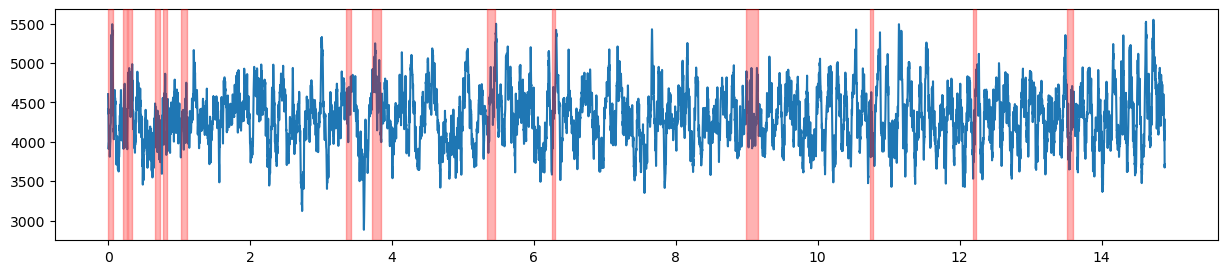

In [268]:
trNum = 1
inds = np.where(lapID[:,0] == trNum)[0]
trial_neuro_data = channel_six[inds]
time = simulate_time(len(trial_neuro_data), SAMPLING_FREQUENCY)
speed = np.zeros(len(time))

# # Reshape trial_neuro_data to 2D array if needed
trial_neuro_data_2d = trial_neuro_data.reshape(-1, 1)  # Reshaping to 2D with one channel

# Use trial-specific data and time for ripple detection
filtered_lfps = filter_ripple_band(trial_neuro_data_2d)
Kay_ripple_times = Kay_ripple_detector(time, filtered_lfps, speed, SAMPLING_FREQUENCY)

display(Kay_ripple_times)

# Visualization
fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(time, trial_neuro_data)
for ripple in Kay_ripple_times.itertuples():
    ax.axvspan(ripple.start_time, ripple.end_time, alpha=0.3, color="red", zorder=1000)
plt.show()


Here we did the data collection and transformation and analyse

In [269]:
num_trials = int(max(lapID[:, 0]))
df = pd.DataFrame()
for trNum in range(1, num_trials):
    inds = np.where(lapID[:,0] == trNum)[0]
    trial_neuro_data = channel_six[inds]
    time = simulate_time(len(trial_neuro_data), SAMPLING_FREQUENCY)
    speed = np.zeros(len(time))

    # # Reshape trial_neuro_data to 2D array if needed
    trial_neuro_data_2d = trial_neuro_data.reshape(-1, 1)  # Reshaping to 2D with one channel

    # Use trial-specific data and time for ripple detection
    filtered_lfps = filter_ripple_band(trial_neuro_data_2d)
    Kay_ripple_times = Kay_ripple_detector(time, filtered_lfps, speed, SAMPLING_FREQUENCY)

    # Add 'trNum' column to kay_ripples_times
    Kay_ripple_times['trNum'] = trNum

    # Concatenate kay_ripples_times to df
    df = pd.concat([df, Kay_ripple_times], ignore_index=True)

df.columns

Index(['start_time', 'end_time', 'duration', 'mean_zscore', 'median_zscore',
       'max_zscore', 'min_zscore', 'speed_at_start', 'speed_at_end',
       'max_speed', 'min_speed', 'median_speed', 'mean_speed', 'trNum'],
      dtype='object')

In [270]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

In [271]:
# Calculating average number of ripples per second per trial
trial_stats = df.groupby('trNum').agg({
    'start_time': 'first',
    'end_time': 'last',
    'trNum': 'size'
})
trial_stats['trial_duration'] = trial_stats['end_time'] - trial_stats['start_time']
trial_stats['avg_ripples_per_sec'] = trial_stats['trNum'] / trial_stats['trial_duration']

# Calculating total and average duration of ripples per event per trial
trial_stats['total_duration'] = df.groupby('trNum')['duration'].sum()
trial_stats['avg_duration_per_event'] = trial_stats['total_duration'] / trial_stats['trNum']

# Renaming 'trNum' column to 'Ripple Count'
trial_stats_renamed = trial_stats.rename(columns={'trNum': 'ripple_count'})
df = trial_stats_renamed.reset_index()


df.head()


,trNum,start_time,end_time,ripple_count,trial_duration,avg_ripples_per_sec,total_duration,avg_duration_per_event
0,1,0.0048,13.5952,14,13.5904,1.030139,1.0432,0.074514
1,2,0.1984,17.9552,17,17.7568,0.957380,1.1680,0.068706
2,3,0.6048,6.4736,8,5.8688,1.363141,0.4992,0.062400
3,4,0.3648,21.6336,22,21.2688,1.034379,1.3408,0.060945
4,5,0.5440,16.7952,13,16.2512,0.799941,1.0144,0.078031


In [272]:
# Define predictor and response variables
X = df[['avg_ripples_per_sec', 'avg_duration_per_event']]
y = df['trNum']

# Add a constant term to the independent variable matrix
X = sm.add_constant(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model using statsmodels
model = sm.OLS(y_train, X_train)

# Fit the model
results = model.fit()

# Print summary statistics
print(results.summary())

# Make predictions on the test set
y_pred = results.predict(X_test)


                            OLS Regression Results                            
Dep. Variable:                  trNum   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     1.860
Date:                Thu, 14 Dec 2023   Prob (F-statistic):              0.163
Time:                        00:01:05   Log-Likelihood:                -335.56
No. Observations:                  72   AIC:                             677.1
Df Residuals:                      69   BIC:                             684.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     77

Here we plotted avg_ripples_per_sec' and another for 'avg_duration_per_event' aganist trNum to see if there really wasn't any relationship and at last there wasn't

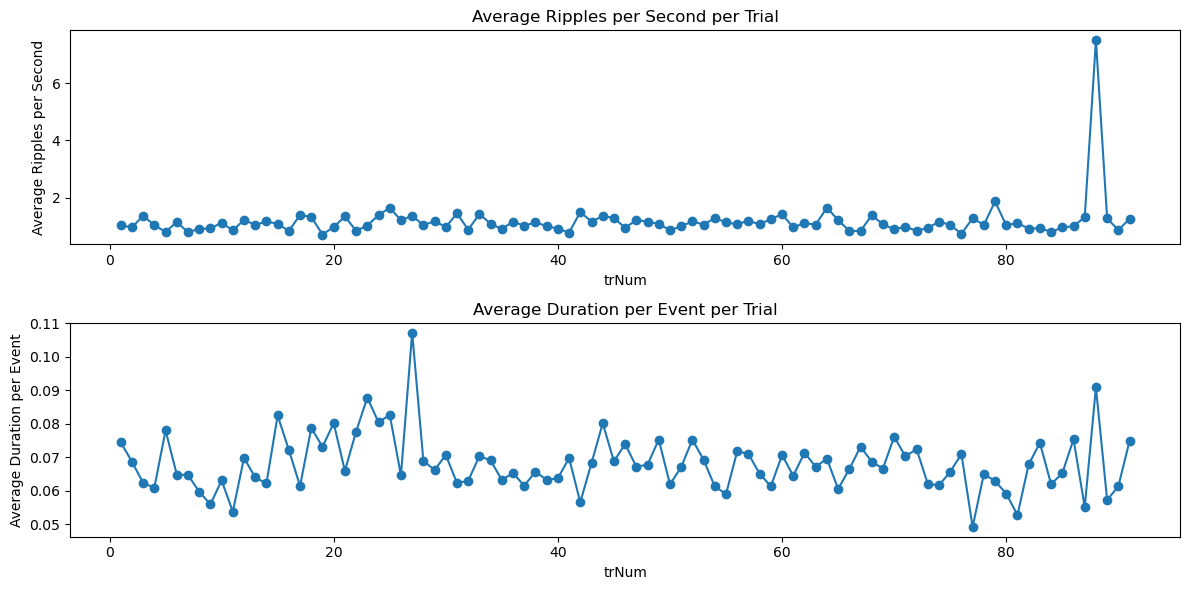

In [274]:
# Assuming trial_stats is the DataFrame you provided
plt.figure(figsize=(12, 6))

# Plotting avg_ripples_per_sec
plt.subplot(2, 1, 1)
plt.plot(df['trNum'], df['avg_ripples_per_sec'], marker='o', linestyle='-')
plt.title('Average Ripples per Second per Trial')
plt.xlabel('trNum')
plt.ylabel('Average Ripples per Second')

# Plotting avg_duration_per_event
plt.subplot(2, 1, 2)
plt.plot(df['trNum'], df['avg_duration_per_event'], marker='o', linestyle='-')
plt.title('Average Duration per Event per Trial')
plt.xlabel('trNum')
plt.ylabel('Average Duration per Event')

plt.tight_layout()
plt.show()